In [1]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.stats import norm, skewnorm

In [2]:
def rms(x, axis=None):
    if axis is not None:
        return np.sqrt(np.sum(x**2, axis=axis) / x.shape[axis])
    return np.sqrt(np.sum(x**2) / x.size)
normal_pdf = lambda mu, sigma, x: np.exp(-(x - mu)**2 / (2 * sigma**2))/(np.sqrt(2 * np.pi * sigma**2))

In [3]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [4]:

zones = ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']

test_z_scores_dict = dict()
test_z_scores = []

z_scores_dict = dict()
z_scores = []

relative_perfs = pd.DataFrame()
relative = []

folder = ".\\experiments\\vanilla_comp\\"
for fname in os.listdir(folder):
    if fname.endswith("relative_perfs.npy"):
        month = fname[12:15]
        relative_perfs[month] = np.load(os.path.join(folder, fname))
        relative.extend(relative_perfs[month])
    if fname.endswith("test_z_scores.npy"):
        month = fname[12:15]
        test_z_scores_dict[month] = np.load(os.path.join(folder, fname))
        test_z_scores.extend((test_z_scores_dict[month][:, :, 0][0]).tolist())
    elif fname.endswith("z_scores.npy"):
        month = fname[12:15]
        z_scores_dict[month] = np.load(os.path.join(folder, fname))
        z_scores.extend((z_scores_dict[month][:, :, 0][0]).tolist())
relative_perfs.index = ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
relative_perfs = relative_perfs.T
relative_perfs = relative_perfs.loc[months]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['Jan', 'Mar', 'Apr', 'Jun', 'Jul', 'Sep', 'Nov'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
relative_perfs["avg"] = relative_perfs.mean(axis=1)
relative_perfs

In [7]:
np.std(relative)

11.577186427182768

In [8]:
# 95\% confidence interval (not accurate, these samples are not independent). We assume that the 6 months we tested on (every other month) are representative
# of our overall performance on the 6 rounds of GEFCom2017. (maybe explain more why this is as fair of a comparison as it gets)
me = np.mean(relative), 
er = np.std(relative_perfs.avg, ddof=1) / np.sqrt(12)  # ?
print(me, 2 * er)
me - 2 * er, me + 2 * er

(11.294098729931662,) 5.248581219648191


(array([6.04551751]), array([16.54267995]))

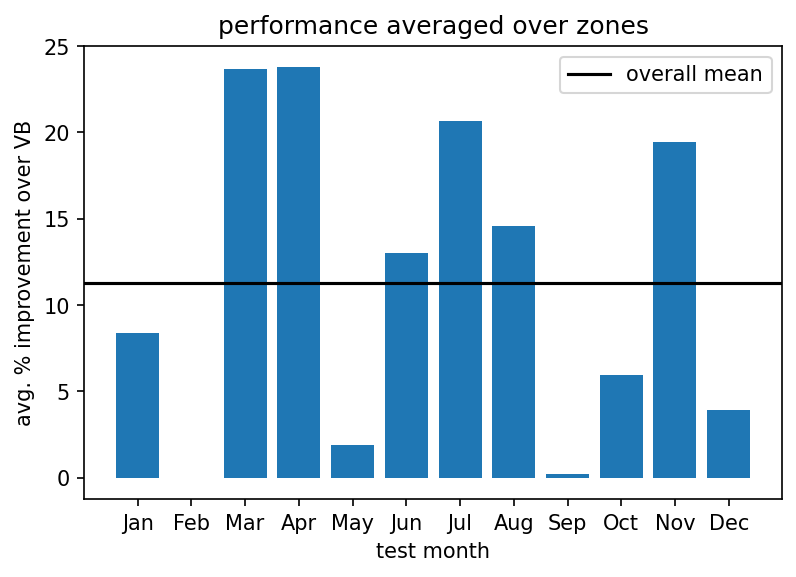

In [10]:
plt.figure(dpi=150)
plt.bar(np.arange(12), relative_perfs.avg, tick_label=relative_perfs.index)
plt.axhline(me, color="k", label="overall mean")
plt.title("performance averaged over zones")
plt.ylabel("avg. % improvement over VB")
plt.xlabel("test month")
plt.legend()

(-0.30935511487652756, 1.2199308014257895)

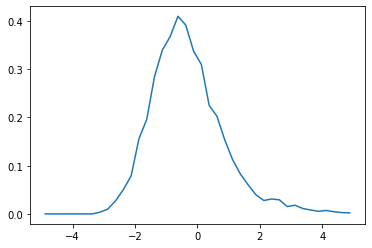

In [11]:
z_hist, bin_edges = np.histogram(test_z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman test z-scores")
# plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
# plt.title(list(all_data.keys())[i])
np.mean(test_z_scores), np.mean(rms(np.array(test_z_scores)))

In [12]:
mar_z = np.array(test_z_scores_dict["Mar"])
mar_z.std(axis=1)

array([[1.21308564],
       [0.91726423],
       [1.1737755 ],
       [1.45926772],
       [1.20578041],
       [1.20769826],
       [1.19970282],
       [1.27310501],
       [1.28774317]])

(-0.02707384298888987, 0.9737972309432206)

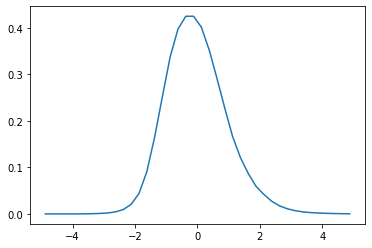

In [13]:
z_hist, bin_edges = np.histogram(z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman train z-scores")
# plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
# plt.title(list(all_data.keys())[i])
np.mean(z_scores), rms(z_scores)

In [14]:
list(np.mean(test_z_scores_dict[mo]) for mo in relative_perfs.index)

[-0.5742616549665047,
 -0.8931502503227425,
 0.15497558559142474,
 -0.3802324627280704,
 -0.2902479867490024,
 -0.11282195854511021,
 -0.48067210306814695,
 -0.610997502938538,
 -0.05055767952011566,
 -0.3121570583114605,
 -0.16144202399979662,
 0.5644286115598942]

# periodic trends in uncertainty

In [5]:
import json
month_name = "Dec"
zone_name = "VT"

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017QualAll.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
zones = list(all_data.keys())
print(zones)

month_idx = months.index(month_name)
print("Testing on month", months[month_idx])
test_start_date = pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00")
test_start = np.argwhere(dates == test_start_date)[0, 0]
test_length = 31 * 24

delay_delta = pd.Timedelta(days=52)
delay = delay_delta.days * 24
train_end_date = test_start_date - delay_delta
train_start_date = train_end_date.replace(year=train_end_date.year - 11)
train_start = np.argwhere(dates == train_start_date)[0, 0]
train_length_delta = train_end_date - train_start_date
train_through = train_length_delta.days * 24
pre_length_delta = train_length_delta * 0.5 # the length of time at the beginning of the trianing period to hide from mu
pre_length = pre_length_delta.days * 24

print("MONTH:", month_name)
data = np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64).T

# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)
predict_through = train_through + delay + test_length
x = data[train_start:][:predict_through]

['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
Testing on month Dec
MONTH: Dec
data (113952, 1)


In [6]:
folder = ".\\experiments\\periodic_uncertainty\\"
for fname in os.listdir(folder):
    if fname.endswith("test_z_scores.npy"):
        print(fname)
        unc_test_z_scores = np.load(os.path.join(folder, fname))
    elif fname.endswith("z_scores.npy"):
        print(fname)
        unc_z_scores = np.load(os.path.join(folder, fname))
    elif fname.endswith("mu.npy"):
        print(fname)
        mu_hat = np.load(os.path.join(folder, fname))
    elif fname.endswith("sigma.npy"):
        print(fname)
        sigma_hat = np.load(os.path.join(folder, fname))
    elif fname.endswith("alpha.npy"):
        print(fname)
        alpha_hat = np.load(os.path.join(folder, fname))

control_DecVT_train_start=15528_2021-04-13_00.24.59.735103trained15528-96432_alpha.npy
control_DecVT_train_start=15528_2021-04-13_00.24.59.735103trained15528-96432_mu.npy
control_DecVT_train_start=15528_2021-04-13_00.24.59.735103trained15528-96432_sigma.npy
control_DecVT_train_start=15528_2021-04-13_04.12.20.853126test_z_scores.npy
control_DecVT_train_start=15528_2021-04-13_04.12.20.853126z_scores.npy


In [7]:
start = 0
idx = train_through
import time
now = time.time()
quantiles = skewnorm.cdf(x[start:idx], alpha_hat[start:idx], loc=mu_hat[start:idx], scale=sigma_hat[start:idx])
deskewed_z_scores = norm.ppf(quantiles)
print(time.time() - now)

40.11898326873779


(inf, inf)

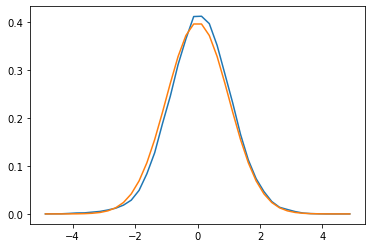

In [8]:
z_hist, bin_edges = np.histogram(deskewed_z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman train z-scores")
plt.plot(z_axis, norm.pdf(z_axis), label="Standard Normal Curve")
np.mean(deskewed_z_scores), rms(deskewed_z_scores)

<IPython.core.display.Javascript object>


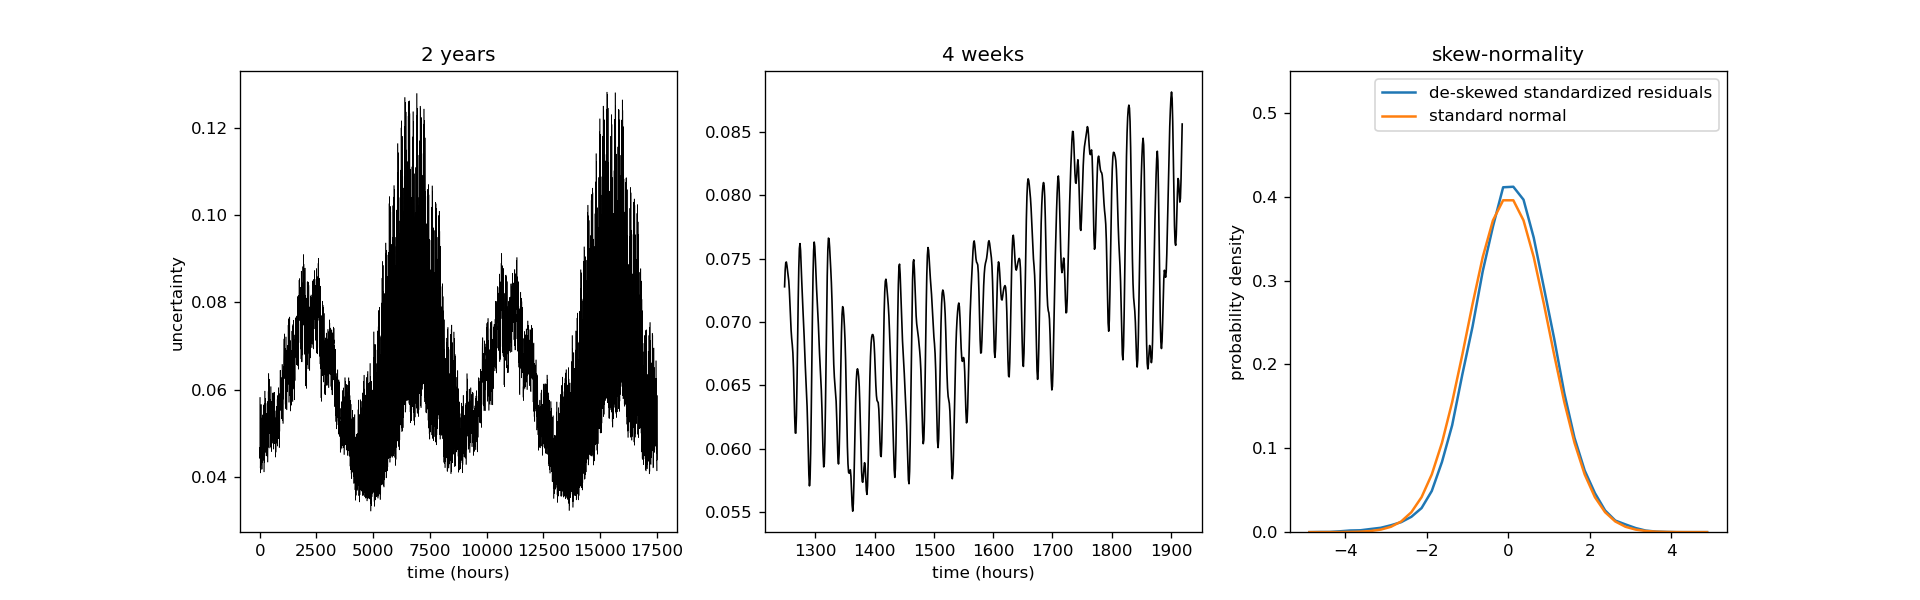

In [13]:
%matplotlib notebook
std_hat = skewnorm.std(alpha_hat, loc=mu_hat, scale=sigma_hat)
plt.subplots(figsize=(16, 5))
plt.subplot(131)
plt.title("2 years")
plt.plot(std_hat[:8760 * 2], linewidth=0.35, color="k")
plt.ylabel("uncertainty")
plt.xlabel("time (hours)")
plt.subplot(132)
plt.title("4 weeks")
st = 0
plt.plot(np.arange(st, st + 4 * 168), std_hat[delay + st:delay + st + 4 * 168], linewidth=1, color="k")
plt.xlabel("time (hours)")
plt.subplot(133)
plt.plot(z_axis, z_hist, label="de-skewed standardized residuals")
plt.plot(z_axis, norm.pdf(z_axis), label="standard normal")
plt.title("skew-normality")
plt.ylabel("probability density")
plt.ylim([0, 0.55])
plt.legend()

In [14]:
ilinet = pd.read_csv("./flu/ILINet.csv")
ilinet

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,1997,40,1.101480,1.216860,179,X,157,205,X,29,570,192,46842
1,National,X,1997,41,1.200070,1.280640,199,X,151,242,X,23,615,191,48023
2,National,X,1997,42,1.378760,1.239060,228,X,153,266,X,34,681,219,54961
3,National,X,1997,43,1.199200,1.144730,188,X,193,236,X,36,653,213,57044
4,National,X,1997,44,1.656180,1.261120,217,X,162,280,X,41,700,213,55506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,National,X,2021,10,0.890914,0.906870,3206,3758,X,3782,1888,1359,13993,3262,1542999
1224,National,X,2021,11,0.908314,0.939333,3482,3897,X,3812,1884,1346,14421,3204,1535239
1225,National,X,2021,12,0.943712,0.965503,3784,4177,X,3863,2021,1304,15149,3152,1569026
1226,National,X,2021,13,0.973590,1.006460,4074,4338,X,4001,2077,1223,15713,3174,1561211


In [24]:
data = ilinet["ILITOTAL"]

<IPython.core.display.Javascript object>


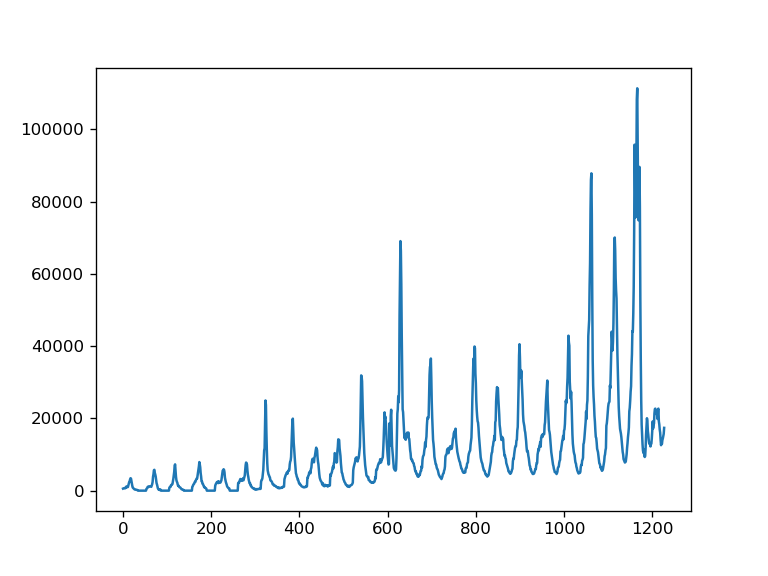

In [25]:
%matplotlib notebook
plt.plot(data)